### MATCH DEEP FIELD OBJECTS TO BALROG DETECTION FILE ###
To make sure the ID is the same

In [1]:
import numpy as np
import fitsio as fio
import pylab as plt
import pandas as pd
import astropy.table

In [2]:
#balrog Y3 detetcion file and deep field ra,dec file

balrog_detection_file = "/global/cfs/cdirs/des/severett/Balrog/run2a/stacked_catalogs/1.4/sof/balrog_detection_catalog_sof_run2a_v1.4.fits"
deep_field_file = "/pscratch/sd/j/jelvinpo/DES/cats/y3/deepfields/Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"
deep_field_wise_file = "/global/cfs/projectdirs/des/nweaverd/y3_deepfields/dr10.0/south/matched/merged_ls-dr10.0-Y3_DEEP_FIELDS_PHOTOM_ang_mag.fits"


In [ ]:
balrog_detection_table = astropy.table.Table.read(balrog_detection_file)
balrog_detection = balrog_detection_table[['true_id']].to_pandas()
deep_field = astropy.table.Table.read(deep_field_file).to_pandas()


In [63]:
balrog_detection_with_deepcoord = balrog_detection.merge(deep_field, how='left', left_on='true_id', right_on='ID')

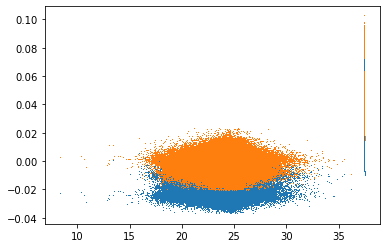

In [72]:
x0 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_G'])
x1 = np.array(balrog_detection_with_deepcoord['BDF_MAG_DERED_CALIB_G'])
y = np.array(balrog_detection_table['true_bdf_mag_deredden'][:,0])
plt.plot(x0,y-x1,',')
plt.plot(x0,y-x0,',')

### ADD N_INJECTION N_DETECTIONS TO WISE MATCHED DEEP FIELDS###
+make plot showing fraction of matches vs magnitude

In [3]:
#load the matched deep field catalog + balrog detections

balrog_detection_table = astropy.table.Table.read(balrog_detection_file)
deep_field = astropy.table.Table.read(deep_field_file)
deep_field_wise = astropy.table.Table.read(deep_field_wise_file)

In [31]:
#count number of times each deep field object was injected/detected
import collections
count_inj = collections.Counter(balrog_detection_table['true_id'])
count_det = collections.Counter(balrog_detection_table['true_id'][balrog_detection_table['detected'] == 1])

injected_id = np.unique(balrog_detection_table["true_id"]).data
n_injections = np.array([count_inj[i] for i in injected_id])
n_detections = np.array([count_det[i] for i in injected_id])


In [95]:
#match injected id list to the matched deep fieled catalog
injected_id_pd = astropy.table.Table(data=[injected_id], names=['INJ_ID']).to_pandas()
injected_id_merged = injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','BDF_MAG_DERED_I']].to_pandas(), how='left', left_on='INJ_ID', right_on='ID')
injected_flux_W1 = np.array(injected_id_merged['FLUX_W1'])
injected_imag = np.array(injected_id_merged['BDF_MAG_DERED_I'])

In [ ]:
#select matches/positive matches
has_wise_match = ~np.isnan(injected_flux_W1)
has_pos_wise_match = injected_flux_W1 > 0.

In [91]:
#get total fractions

frac_injections_with_wise_match = np.sum(n_injections[has_wise_match])/np.sum(n_injections)
frac_detections_with_wise_match = np.sum(n_detections[has_wise_match])/np.sum(n_detections)

frac_injections_with_pos_wise_match = np.sum(n_injections[has_pos_wise_match])/np.sum(n_injections)
frac_detections_with_pos_wise_match = np.sum(n_detections[has_pos_wise_match])/np.sum(n_detections)

print("frac Y3 injections with deep-field WISE match =", frac_injections_with_wise_match)
print("frac Y3 detections with deep-field WISE match =", frac_detections_with_wise_match)

print("frac Y3 injections with positive-flux deep-field WISE match =", frac_injections_with_pos_wise_match)
print("frac Y3 detections with positive-flux deep-field WISE match =", frac_detections_with_pos_wise_match)


In [111]:
#get fractions as a function of true i-band magnitude

ilim_list = np.linspace(22, 25, 10)
frac_injections_with_wise_match = np.array([])
frac_detections_with_wise_match = np.array([])
frac_injections_with_pos_wise_match = np.array([])
frac_detections_with_pos_wise_match = np.array([])
for ilim in ilim_list:
    select_ilim = (injected_imag < ilim)
    
    frac_injections_with_wise_match_1 = np.sum(n_injections[select_ilim*has_wise_match])/np.sum(n_injections[select_ilim])
    frac_detections_with_wise_match_1 = np.sum(n_detections[select_ilim*has_wise_match])/np.sum(n_detections[select_ilim])

    frac_injections_with_pos_wise_match_1 = np.sum(n_injections[select_ilim*has_pos_wise_match])/np.sum(n_injections[select_ilim])
    frac_detections_with_pos_wise_match_1 = np.sum(n_detections[select_ilim*has_pos_wise_match])/np.sum(n_detections[select_ilim])

    frac_injections_with_wise_match = np.append(frac_injections_with_wise_match, frac_injections_with_wise_match_1)
    frac_detections_with_wise_match = np.append(frac_detections_with_wise_match, frac_detections_with_wise_match_1)
    frac_injections_with_pos_wise_match = np.append(frac_injections_with_pos_wise_match, frac_injections_with_pos_wise_match_1)
    frac_detections_with_pos_wise_match = np.append(frac_detections_with_pos_wise_match, frac_detections_with_pos_wise_match_1)


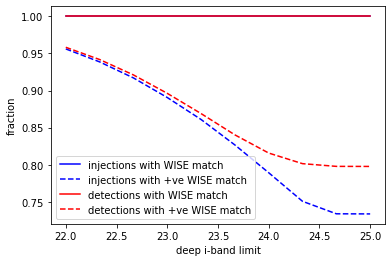

In [112]:
plt.plot(ilim_list, frac_injections_with_wise_match, '-', color='b', label='injections with WISE match')
plt.plot(ilim_list, frac_injections_with_pos_wise_match, '--', color='b', label='injections with +ve WISE match')

plt.plot(ilim_list, frac_detections_with_wise_match, '-', color='r', label='detections with WISE match')
plt.plot(ilim_list, frac_detections_with_pos_wise_match, '--', color='r', label='detections with +ve WISE match')
plt.xlabel('deep i-band limit')
plt.ylabel('fraction')
plt.legend()
plt.savefig('frac_of_injections_with_wise_flux.png')


### What is the fraction of WISE matches for MAGLIM objects?###

In [147]:
balrog_maglim_file = "/global/cfs/cdirs/des/jelvinpo/cats/y3/balrog/run2/lens_samples_run2_v1.4/maglim_lens_v2p2_flux_balrog_run2_v1.4_masked.fits.gz"
balrog_maglim = fio.read(balrog_maglim_file)

y3_maglim_injected_id_pd = astropy.table.Table(data=[balrog_maglim["true_id"]], names=['INJ_ID']).to_pandas()
y3_maglim_injected_id_merged = y3_maglim_injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','BDF_MAG_DERED_I']].to_pandas(), how='left', left_on='INJ_ID', right_on='ID')
y3_maglim_injected_flux_W1 = np.array(y3_maglim_injected_id_merged['FLUX_W1'])

y3_maglim_has_wise_match = ~np.isnan(y3_maglim_injected_flux_W1)
y3_maglim_has_pos_wise_match = y3_maglim_injected_flux_W1 > 0.

In [149]:
frac_y3maglim_with_wise_match = np.sum(y3_maglim_has_wise_match.astype('int'))/len(balrog_maglim)
frac_y3maglim_with_pos_wise_match = np.sum(y3_maglim_has_wise_match.astype('int'))/len(balrog_maglim)

print("frac Y3 balrog-maglim with deep-field WISE match =", frac_y3maglim_with_wise_match )
print("frac Y3 balrog-maglim with positive-flux deep-field WISE match =", frac_y3maglim_with_pos_wise_match )


frac Y3 balrog-maglim injections with deep-field WISE match = 0.9837162088166662
frac Y3 balrog-maglim with positive-flux deep-field WISE match = 0.9837162088166662


### NOW TRY THE Y6 DF INJECTIONS (SOME CUTS APPLIED vs y3) ###

In [143]:
y6_df_injections_file = "/global/cfs/cdirs/des/y6-balrog/inputs/BALROG_RUN2_DEEP_CAT_FLAG0INVHS1BDFLT254v4_weighted_v2.fits"
y6_df_injections = fio.read(y6_df_injections_file)

y6_injected_id_pd = astropy.table.Table(data=[y6_df_injections['id']], names=['INJ_ID']).to_pandas()
y6_injected_id_merged = y6_injected_id_pd.merge(deep_field_wise[['ID','FLUX_W1','BDF_MAG_DERED_I']].to_pandas(), how='left', left_on='INJ_ID', right_on='ID')
y6_injected_flux_W1 = np.array(y6_injected_id_merged['FLUX_W1'])



In [141]:
#select matches/positive matches
y6_has_wise_match = ~np.isnan(y6_injected_flux_W1)
y6_has_pos_wise_match = y6_injected_flux_W1 > 0.


In [142]:
#get total fractions

frac_y6inj_with_wise_match = np.sum(y6_has_wise_match.astype('int'))/len(y6_df_injections)
frac_y6inj_with_pos_wise_match = np.sum(y6_has_pos_wise_match.astype('int'))/len(y6_df_injections)

print("frac Y6 injections with deep-field WISE match =", frac_y6inj_with_wise_match)
print("frac Y6 injections with positive-flux deep-field WISE match =", frac_y6inj_with_pos_wise_match)


frac Y6 injections with deep-field WISE match = 0.9536274179060192
frac Y6 injections with positive-flux deep-field WISE match = 0.6097533217628817


1230145